In [2]:
%pip install seaborn

     -------------------------------------- 294.9/294.9 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

# Enable GPU optimization
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# ===========================
# 1️⃣ OPTIMIZED SENSOR DATA PROCESSING
# ===========================
def load_sensor_data():
    DATA_PATH = r"C:\Users\sarth\Downloads\human+activity+recognition+using+smartphones\UCI HAR Dataset\UCI HAR Dataset"
    
    # Parallel file reading
    def read_file(path):
        return pd.read_csv(path, sep=r'\s+', header=None, engine='python')
    
    with ThreadPoolExecutor() as executor:
        futures = {
            'X_train': executor.submit(read_file, os.path.join(DATA_PATH, "train", "X_train.txt")),
            'y_train': executor.submit(read_file, os.path.join(DATA_PATH, "train", "y_train.txt")),
            'X_test': executor.submit(read_file, os.path.join(DATA_PATH, "test", "X_test.txt")),
            'y_test': executor.submit(read_file, os.path.join(DATA_PATH, "test", "y_test.txt")),
            'features': executor.submit(read_file, os.path.join(DATA_PATH, "features.txt"))
        }
        
        results = {k: v.result() for k, v in futures.items()}
    
    # Process features
    features_list = results['features'].iloc[:,1].tolist()
    features = [f"{col}_{i}" if features_list.count(col) > 1 else col 
               for i, col in enumerate(features_list)]
        # Combine and process data
    X_data = pd.concat([results['X_train'], results['X_test']]).set_axis(features, axis=1)
    y_data = pd.concat([results['y_train'], results['y_test']]).set_axis(["Activity"], axis=1)
    
    # Normalize and encode
    X_sensor = StandardScaler().fit_transform(X_data)
    y_sensor = LabelEncoder().fit_transform(y_data)
    
    # Reshape for LSTM
    X_sensor = X_sensor.reshape(-1, 1, X_sensor.shape[1])
    
    return X_sensor, y_sensor

# ===========================
# 2️⃣ OPTIMIZED IMAGE PROCESSING
# ===========================
def load_image_data():
    HMDB_PATH = r"C:\Users\sarth\Downloads\archive (14)\HMDB51"
    IMG_SIZE = (112, 112)
    FRAMES_PER_FOLDER = 16
    BATCH_SIZE = 32  # Optimize based on GPU memory
    
    # Load MobileNetV2 with optimizations
    base_cnn = MobileNetV2(weights="imagenet", include_top=False, 
                         input_shape=(112, 112, 3), pooling='avg')
    cnn_model = Model(inputs=base_cnn.input, outputs=base_cnn.output)
    
    # Precompile the model
    dummy_input = tf.zeros((1, *IMG_SIZE, 3))
    _ = cnn_model(dummy_input)
    
    image_features = []
    image_labels = []
    
    # Process class folders in parallel
    def process_class(class_label, class_folder):
        class_path = os.path.join(HMDB_PATH, class_folder)
        if not os.path.isdir(class_path):
            return None
            
        class_features = []
        video_folders = os.listdir(class_path)
        
        for video_folder in video_folders[:100]:  # Limit for testing
            video_path = os.path.join(class_path, video_folder)
            if not os.path.isdir(video_path):
                continue
                
            # Batch process images
            image_paths = []
            
            for img_file in sorted(os.listdir(video_path))[:FRAMES_PER_FOLDER]:
                if img_file.lower().endswith((".jpg", ".png", ".jpeg")):
                    img_path = os.path.join(video_path, img_file)
                    image_paths.append(img_path)
            
            # Process images in batches
            if image_paths:
                dataset = tf.data.Dataset.from_tensor_slices(image_paths)
                dataset = dataset.map(
                    lambda x: tf.image.decode_jpeg(tf.io.read_file(x), channels=3),
                    num_parallel_calls=tf.data.AUTOTUNE
                )
                dataset = dataset.map(
                    lambda x: tf.image.resize(x, IMG_SIZE),
                    num_parallel_calls=tf.data.AUTOTUNE
                )
                dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
                
                video_features = []
                for batch in dataset:
                    batch = tf.cast(batch, tf.float32) / 255.0
                    features = cnn_model(batch, training=False)
                    video_features.append(features.numpy())
                
                if video_features:
                    class_features.append(np.mean(np.concatenate(video_features), axis=0))
        
        return (class_features, [class_label]*len(class_features)) if class_features else None
    
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = []
        for class_label, class_folder in enumerate(os.listdir(HMDB_PATH)):
            futures.append(executor.submit(process_class, class_label, class_folder))
            
        for future in tqdm(futures, desc="Processing classes"):
            result = future.result()
            if result:
                feats, labels = result
                image_features.extend(feats)
                image_labels.extend(labels)
    
    return np.array(image_features), np.array(image_labels)

# ===========================
# 3️⃣ MAIN EXECUTION
# ===========================
if __name__ == "__main__":
    print("🚀 Processing sensor data...")
    X_sensor, y_sensor = load_sensor_data()
    np.save("sensor_features.npy", X_sensor)
    np.save("sensor_labels.npy", y_sensor)
    
    print("\n🚀 Processing image data...")
    X_image, y_image = load_image_data()
    if len(X_image) > 0:
        np.save("image_features.npy", X_image)
        np.save("image_labels.npy", y_image)
    else:
        raise ValueError("❌ No valid image features extracted")
    
    print("\n✅ Preprocessing completed!")

KeyboardInterrupt: 

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Dropout, LSTM, 
                                   MultiHeadAttention, LayerNormalization,
                                   GlobalAveragePooling1D, concatenate)
from tensorflow.keras.models import Model

# ===========================
# 3️⃣ MULTIMODAL MODEL (LSTM + TRANSFORMER for Sensor)
# ===========================
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_multimodal_model(X_sensor, X_image, y_sensor):
    """Build and compile the multimodal model"""
    
    # Load saved features
    X_sensor = np.load("sensor_features.npy")
    y_sensor = np.load("sensor_labels.npy")
    X_image = np.load("image_features.npy")
    y_image = np.load("image_labels.npy")

    # Match sizes
    num_samples = min(len(X_sensor), len(X_image))
    X_sensor = X_sensor[:num_samples]
    X_image = X_image[:num_samples]
    y_sensor = y_sensor[:num_samples]

    # Sensor branch
    sensor_input = Input(shape=X_sensor.shape[1:], name="Sensor_Input")
    x1 = LSTM(64, return_sequences=True)(sensor_input)
    x1 = TransformerEncoder(embed_dim=64, num_heads=4, ff_dim=128)(x1)
    x1 = GlobalAveragePooling1D()(x1)
    x1 = Dense(64, activation='relu')(x1)
    x1 = Dropout(0.3)(x1)

    # Image branch
    image_input = Input(shape=X_image.shape[1:], name="Image_Input")
    x2 = Dense(256, activation='relu')(image_input)
    x2 = Dropout(0.3)(x2)
    x2 = Dense(128, activation='relu')(x2)

    # Merge and output
    merged = concatenate([x1, x2])
    merged = Dense(128, activation='relu')(merged)
    merged = Dropout(0.4)(merged)
    output = Dense(len(np.unique(y_sensor)), activation='softmax')(merged)

    # Compile model
    model = Model(inputs=[sensor_input, image_input], outputs=output)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Initialize and summarize model
if __name__ == "__main__":
    # Load sample data for shape reference
    sample_sensor = np.load("sensor_features.npy")
    sample_image = np.load("image_features.npy")
    sample_labels = np.load("sensor_labels.npy")
    
    model = build_multimodal_model(sample_sensor, sample_image, sample_labels)
    model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Sensor_Input        │ (None, 1, 561)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 1, 64)     │    160,256 │ Sensor_Input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 1, 64)     │     83,200 │ lstm[0][0]        │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Image_Input         │ (None, 1280)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ transformer_enco… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    327,936 │ Image_Input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     32,896 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     24,704 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 6)         │        774 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 633,926 (2.42 MB)

 Trainable params: 633,926 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5602 - loss: 1.1084 - val_accuracy: 0.8716 - val_loss: 0.3269
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9292 - loss: 0.2272 - val_accuracy: 0.9275 - val_loss: 0.2398
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9455 - loss: 0.1622 - val_accuracy: 0.9539 - val_loss: 0.1527
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9735 - loss: 0.1020 - val_accuracy: 0.9304 - val_loss: 0.2544
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9649 - loss: 0.1074 - val_accuracy: 0.9206 - val_loss: 0.3362
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9739 - loss: 0.0814 - val_accuracy: 0.9431 - val_loss: 0.2554
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9831 - loss: 0.0589 - val_accuracy: 0.9294 - val_loss: 0.2717
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9474 - loss: 0.1537 - val_acc

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9980 - loss: 0.0113
✅ Final Accuracy: 98.73%
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       864
           1       1.00      0.96      0.98       737
           2       0.96      1.00      0.98       678
           3       0.98      0.98      0.98       879
           4       0.98      0.99      0.98       977
           5       1.00      1.00      1.00       965

    accuracy                           0.99      5100
   macro avg       0.99      0.99      0.99      5100
weighted avg       0.99      0.99      0.99      5100



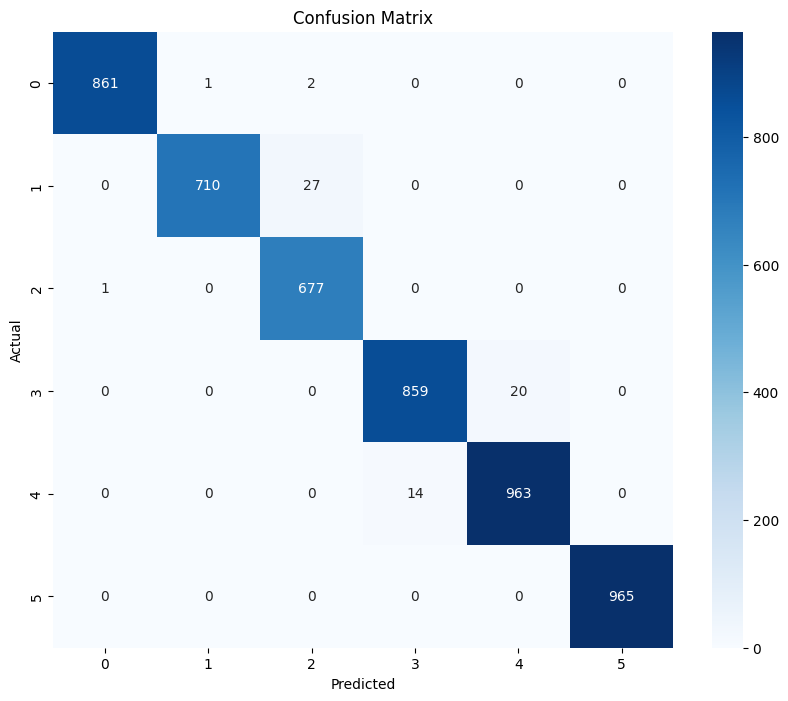

In [14]:
# ===========================
# 4️⃣ TRAINING & EVALUATION
# ===========================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# ===========================
# 4️⃣ TRAINING & EVALUATION
# ===========================
history = model.fit([X_sensor, X_image], y_sensor, epochs=20, batch_size=32, validation_split=0.2)
model.save("multimodal_ucihar_hmdb51_model.h5")

loss, acc = model.evaluate([X_sensor, X_image], y_sensor)
print(f"✅ Final Accuracy: {acc*100:.2f}%")

y_pred_probs = model.predict([X_sensor, X_image])
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n📊 Classification Report:")
print(classification_report(y_sensor, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_sensor, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [10]:

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RepeatVector, TimeDistributed
# ===========================
# 5️⃣ ANOMALY DETECTION ADDITION
# ===========================

# 1. Autoencoder for Sensor Data Anomaly Detection
sensor_autoencoder = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_sensor.shape[1], X_sensor.shape[2])),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(X_sensor.shape[1]),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_sensor.shape[2]))
])
sensor_autoencoder.compile(optimizer='adam', loss='mse')

# Train only on normal data (assuming class 0 is normal)
normal_idx = np.where(y_sensor == 0)[0]
sensor_autoencoder.fit(X_sensor[normal_idx], X_sensor[normal_idx], 
                      epochs=20, batch_size=32, validation_split=0.1)

# 2. One-Class SVM for Image Data Anomaly Detection
scaler = StandardScaler()
X_image_scaled = scaler.fit_transform(X_image)
ocsvm = OneClassSVM(nu=0.05, kernel="rbf", gamma="scale")
ocsvm.fit(X_image_scaled[y_image == 0])  # Train only on normal data

# 3. Combined Anomaly Detection
def detect_anomalies(X_sensor, X_image, threshold=0.95):
    # Sensor reconstruction error
    sensor_recon = sensor_autoencoder.predict(X_sensor)
    sensor_errors = np.mean(np.square(X_sensor - sensor_recon), axis=(1, 2))
    
    # Image anomaly scores
    X_image_scaled = scaler.transform(X_image)
    image_scores = -ocsvm.decision_function(X_image_scaled)  # Convert to positive scores
    
    # Combine scores (adjust weights as needed)
    combined_scores = 0.6 * sensor_errors + 0.4 * image_scores
    anomalies = combined_scores > np.percentile(combined_scores, threshold * 100)
    return anomalies, combined_scores

# Detect anomalies
anomalies, scores = detect_anomalies(X_sensor, X_image)

# 4. Visualize Results
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(scores[~anomalies], bins=50, alpha=0.5, label='Normal')
plt.hist(scores[anomalies], bins=50, alpha=0.5, label='Anomaly')
plt.axvline(x=np.percentile(scores, 95), color='r', linestyle='--')
plt.title('Anomaly Score Distribution')
plt.legend()

plt.subplot(122)
plt.scatter(range(len(scores)), scores, c=anomalies, cmap='coolwarm')
plt.title('Anomaly Points Detection')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.tight_layout()
plt.show()

print(f"Detected {sum(anomalies)} anomalies ({sum(anomalies)/len(anomalies)*100:.2f}%)")

c:\Users\sarth\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 107s 637ms/step - loss: 0.9640 - val_loss: 0.4469
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.5007 - val_loss: 0.4190
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.4666 - val_loss: 0.4135
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.4089 - val_loss: 0.3859
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.3742 - val_loss: 0.3548
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.3398 - val_loss: 0.3387
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.3269 - val_loss: 0.3351
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.3099 - val_loss: 0.3330
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.3030 - val_loss: 0.3325
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.2866 - val_loss: 0.3342
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.2738 - val_loss: 0.3288
Epoch 12/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 

NameError: name 'y_image' is not defined

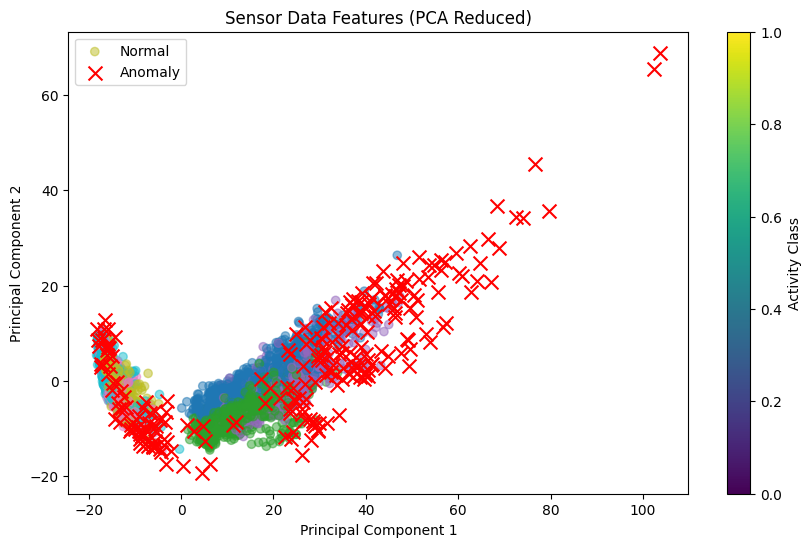

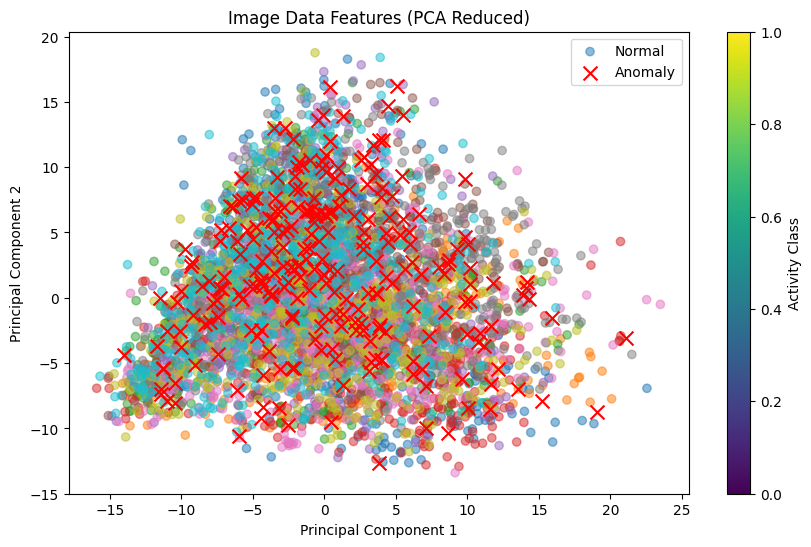

In [19]:
# Enhanced Visualizations
def plot_feature_space(X, y, anomalies, title="Feature Space"):
    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X_2d[~anomalies, 0], X_2d[~anomalies, 1], 
                c=y[~anomalies], cmap='tab10', alpha=0.5, label='Normal')
    plt.scatter(X_2d[anomalies, 0], X_2d[anomalies, 1], 
                c='red', marker='x', s=100, label='Anomaly')
    plt.title(f"{title} (PCA Reduced)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.colorbar(label='Activity Class')
    plt.show()

# For sensor data (reshape first)
X_sensor_flat = X_sensor.reshape(X_sensor.shape[0], -1)
plot_feature_space(X_sensor_flat, y_sensor, anomalies, "Sensor Data Features")

# For image data
plot_feature_space(X_image, y_image, anomalies, "Image Data Features")

In [10]:
%pip install seaborn
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     -------------------------------------- 139.8/139.8 kB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 4.4 MB/s eta 0:00:00
     -------------------------------------- 214.0/214.0 kB 3.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import tensorflow as tf
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config


In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'TransformerEncoder': TransformerEncoder})

model = load_model('multimodal_ucihar_hmdb51_model.h5')


In [6]:
import numpy as np

X_sensor = np.load("sensor_features.npy")
X_image = np.load("image_features.npy")
y_sensor = np.load("sensor_labels.npy")  # We'll use it for class names
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Reconstruct label encoder to inverse transform class indices
label_encoder = LabelEncoder()
label_encoder.fit(y_sensor)


LabelEncoder()

In [23]:
import random

idx = random.randint(0, len(X_image) - 1)

sensor_sample = np.expand_dims(X_sensor[idx], axis=0)
image_sample = np.expand_dims(X_image[idx], axis=0)

# Predict
pred = model.predict([sensor_sample, image_sample])
pred_class = np.argmax(pred)
activity_label = label_encoder.inverse_transform([pred_class])[0]

print("Predicted Activity:", activity_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
Predicted Activity: 5


In [24]:
def run_demo():
    idx = random.randint(0, len(X_image) - 1)
    
    sensor_sample = np.expand_dims(X_sensor[idx], axis=0)
    image_sample = np.expand_dims(X_image[idx], axis=0)

    pred = model.predict([sensor_sample, image_sample])
    pred_class = np.argmax(pred)
    activity_label = label_encoder.inverse_transform([pred_class])[0]

    print(f"🧠 Model Prediction: {activity_label} (Sample #{idx})")


In [25]:
run_demo()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
🧠 Model Prediction: 5 (Sample #901)


In [7]:
from sklearn.svm import OneClassSVM
from tensorflow.keras.models import Model
import numpy as np
# ======================
# FIXED ANOMALY DETECTION SETUP
# ======================
def setup_anomaly_detection(X_sensor, X_image, y_sensor, normal_class=0):
    """Train anomaly detectors for each modality"""
    # Ensure we only use samples that exist in both modalities
    min_samples = min(len(X_sensor), len(X_image))
    X_sensor = X_sensor[:min_samples]
    X_image = X_image[:min_samples]
    y_sensor = y_sensor[:min_samples]
    
    # Get normal samples (assuming class 0 is normal)
    normal_idx = np.where(y_sensor == normal_class)[0]
    
    # Verify we have normal samples
    if len(normal_idx) == 0:
        raise ValueError(f"No samples found with class {normal_class}")
    
    # Sensor anomaly detector (Autoencoder)
    print("Training sensor autoencoder...")
    sensor_autoencoder = build_sensor_autoencoder(X_sensor[normal_idx])
    sensor_autoencoder.fit(X_sensor[normal_idx], X_sensor[normal_idx],
                         epochs=20, batch_size=32, verbose=1)
    
    # Image anomaly detector (One-Class SVM)
    print("Training image anomaly detector...")
    image_ocsvm = OneClassSVM(nu=0.05, kernel="rbf", gamma="scale")
    image_ocsvm.fit(X_image[normal_idx])
    
    return sensor_autoencoder, image_ocsvm

# ======================
# UPDATED INTERACTIVE DEMO
# ======================
def interactive_demo_with_anomaly():
    # First align the datasets
    min_samples = min(len(X_sensor), len(X_image), len(y_sensor))
    X_sensor_aligned = X_sensor[:min_samples]
    X_image_aligned = X_image[:min_samples]
    y_sensor_aligned = y_sensor[:min_samples]
    
    # Initialize anomaly detectors
    try:
        sensor_ae, image_ocsvm = setup_anomaly_detection(
            X_sensor_aligned, X_image_aligned, y_sensor_aligned
        )
    except Exception as e:
        print(f"Error initializing anomaly detectors: {e}")
        return
    
    while True:
        print("\n" + "="*50)
        print("ANOMALY DETECTION DEMO:")
        print(f"1. Test random sample (0-{min_samples-1})")
        print("2. Test specific index")
        print("3. Exit")
        choice = input("Select option (1-3): ")
        
        if choice == '1':
            idx = random.randint(0, min_samples - 1)
            analyze_sample(idx, sensor_ae, image_ocsvm, 
                         X_sensor_aligned, X_image_aligned, y_sensor_aligned)
        elif choice == '2':
            idx = int(input(f"Enter index (0-{min_samples-1}): "))
            if 0 <= idx < min_samples:
                analyze_sample(idx, sensor_ae, image_ocsvm,
                             X_sensor_aligned, X_image_aligned, y_sensor_aligned)
            else:
                print(f"Invalid index! Must be between 0-{min_samples-1}")
        elif choice == '3':
            break
        else:
            print("Invalid option!")
def analyze_sample(idx, sensor_ae, image_ocsvm, X_sensor, X_image, y_sensor, threshold=0.95):
    sensor_sample = np.expand_dims(X_sensor[idx], axis=0)
    image_sample = np.expand_dims(X_image[idx], axis=0)
    true_class = y_sensor[idx]
    
    # Activity prediction
    pred = model.predict([sensor_sample, image_sample], verbose=0)
    pred_class = np.argmax(pred)
    pred_label = label_encoder.inverse_transform([pred_class])[0]
    true_label = label_encoder.inverse_transform([true_class])[0]
    
    # Anomaly detection
    sensor_recon = sensor_ae.predict(sensor_sample)
    sensor_error = np.mean(np.square(sensor_sample - sensor_recon))
    image_score = -image_ocsvm.decision_function(image_sample)[0]
    combined_score = 0.6*sensor_error + 0.4*image_score
    
    # Get threshold from normal samples
    normal_idx = np.where(y_sensor == 0)[0]
    normal_scores = [
        0.6*np.mean(np.square(X_sensor[i] - sensor_ae.predict(np.expand_dims(X_sensor[i], 0)))) + 
        0.4*(-image_ocsvm.decision_function(np.expand_dims(X_image[i], 0))[0])
        for i in normal_idx
    ]
    threshold_value = np.percentile(normal_scores, threshold*100)
    is_anomaly = combined_score > threshold_value
    
    # Visualization
    plt.figure(figsize=(15, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(sensor_sample[0,0], 'b-', label='Original')
    plt.plot(sensor_recon[0,0], 'r--', label='Reconstructed')
    plt.title(f'Sensor Data (Error: {sensor_error:.2f})')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    # FIXED: Handle both 1D and 2D image features
    if len(image_sample.shape) > 1 and image_sample.shape[1] > 1:
        plt.bar(range(len(image_sample[0][:50])), image_sample[0][:50])
    else:
        plt.bar(range(len(image_sample[:50])), image_sample[:50])
    plt.title(f'Image Features (Score: {image_score:.2f})')
    
    plt.subplot(1, 3, 3)
    plt.bar(['Sensor', 'Image', 'Combined'], 
            [sensor_error, image_score, combined_score])
    plt.axhline(y=threshold_value, color='r', linestyle='--', label='Threshold')
    plt.title('Anomaly Scores')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    print(f"\nSample #{idx} Analysis:")
    print(f"Activity: True={true_label}, Predicted={pred_label}")
    print(f"Sensor Error: {sensor_error:.2f}")
    print(f"Image Anomaly Score: {image_score:.2f}")
    print(f"Combined Score: {combined_score:.2f} (Threshold: {threshold_value:.2f})")
    print("🚨 ANOMALY DETECTED!" if is_anomaly else "✅ Normal sample")
    print("⚠️ MISCLASSIFICATION" if pred_class != true_class else "✅ Correct classification")
# Run the enhanced demo
if __name__ == "__main__":
    interactive_demo_with_anomaly()

Training sensor autoencoder...
Error initializing anomaly detectors: name 'build_sensor_autoencoder' is not defined


Training sensor autoencoder...


c:\Users\sarth\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1.0307
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5262
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4224
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3763
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3451
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3234
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2987
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2728
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2642
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2618
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2342
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2264
Epoch 13/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2242
Epoch 14/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2192
Epoch 15/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2142
Epoch 1

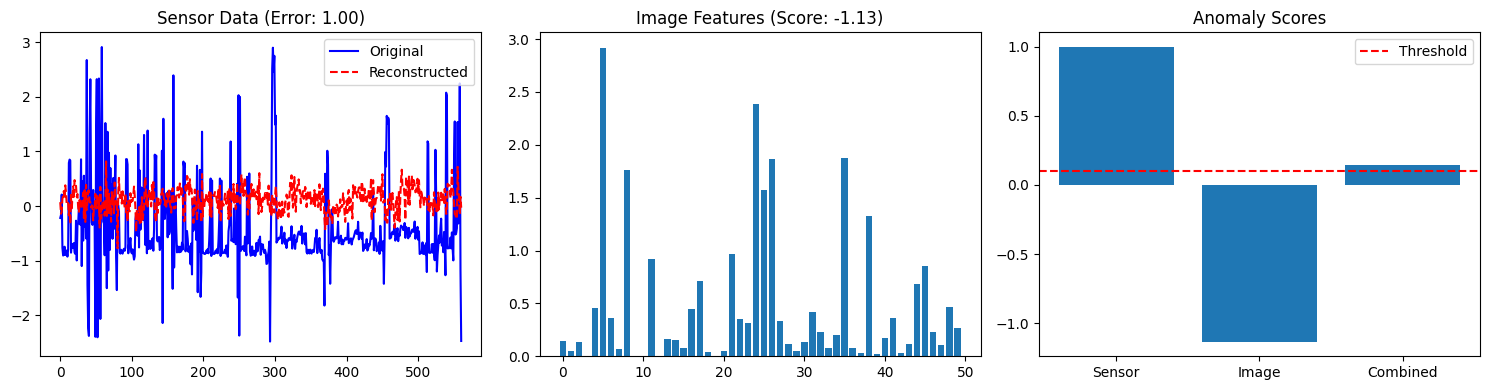


Sample #1525 Analysis:
Activity: True=5, Predicted=5
Sensor Error: 1.00
Image Anomaly Score: -1.13
Combined Score: 0.15 (Threshold: 0.10)
🚨 ANOMALY DETECTED!
✅ Correct classification

ANOMALY DETECTION DEMO:
1. Test random sample (0-5099)
2. Test specific index
3. Exit


In [35]:
if __name__ == "__main__":
    interactive_demo_with_anomaly()